# Error rate
This notebook computes the theoritical minimum error rates of CW decoding in different scenarios.


In [1]:
import numpy as np
from scipy.stats import rayleigh
from scipy.stats import rice
import math
import matplotlib.pyplot as plt

import my_paths
%load_ext autoreload
%autoreload 2

### OOK detection in AWGN
If an unmodulated carrier (CW) is received in the presence of complex Gaussign noise, then the magnitudes of the noise-only samples have Rayleigh distribution, and the magnitudes of the signal-plus-noise samples have Rice distribution. These distributions overlap, which means that the On/Off Key detector (OOK) has non-zero error rate at any SNR. This error rate, as a function of SNR,  may be estimated from the two distributions as shown below.

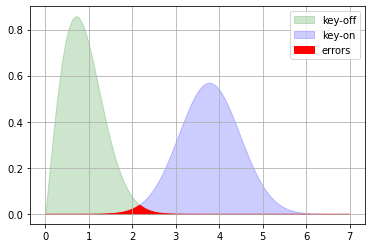

SNR = 8.4 dB, detection error rate = 0.010


In [2]:
noise_rms = 1
signal_amplitude = 3.7

# rms = amp - 3 dB, due to CW duty cycle
signal_rms = signal_amplitude / np.sqrt(2)
snr = 20*math.log10(signal_rms / noise_rms)

sigma = noise_rms  / np.sqrt(2)
b = signal_amplitude / sigma

x = np.linspace(0, 7, 200) 
key_off_pdf = rayleigh.pdf(x, scale=sigma)
key_on_pdf = rice.pdf(x, b=b, scale=sigma)  
err = [min(key_off_pdf[i], key_on_pdf[i]) for i in range(len(x))]

plt.fill_between(x, key_off_pdf, 0, color='g', alpha=0.2, label='key-off')  
plt.fill_between(x, key_on_pdf, 0, color='b', alpha=0.2, label='key-on')  
plt.fill_between(x, err, 0, color='r', label='errors')
plt.legend()
plt.grid(True)
plt.show()

error_rate = sum(err) / (sum(key_off_pdf + key_on_pdf))
print('SNR = {:.1f} dB, detection error rate = {:.3f}'.format(snr, error_rate))

### Morse Code statistics
Compute some statistical characteristics of Morse Code based on the real-world data collected using CW Skimmer and presented in the data_generation.ipynb notebook. The computed values will be used to compute the character error rate (CER) from the bit error rate (BER) by viewing [Morse Code as binary code](https://cs.stackexchange.com/revisions/39922/8)

In [3]:
%%writefile validation/morse_code_stats.py
import numpy as np
import math
import morse_code as mc

# average word length
word_length = np.dot(range(len(mc.word_length_probs)), mc.word_length_probs) / np.sum(mc.word_length_probs)

# morse characters plus word-end space, and their probabilities
codes = list(mc.morse_codes.values()) + ['_']
freqs = mc.morse_char_frequencies + [np.sum(mc.morse_char_frequencies) / word_length]
probs = freqs / sum(freqs)

# morse code lengths, in dot-length symbols
total_bits = np.array([len(code.replace('.', '. ').replace('-','... ') + '  ') for code in codes])
key_on_bits = np.array([len(code.replace('-','...').replace('_','')) for code in codes])
bits_per_char = np.sum(total_bits * probs)

# morse code duty cycle
duty_cycle = np.sum(key_on_bits * probs) / np.sum(total_bits * probs)

# information content of a char
info_bits_per_char = sum(-probs * np.log2(probs))

# measured at 24 WPM
CHARS_PER_SECOND = 2.335555

#print(f'word_length: {word_length}')
#print(f'duty_cycle: {duty_cycle}')
#print(f'bits_per_char: {bits_per_char}')
#rint(f'info_bits_per_char: {info_bits_per_char}\n')

Overwriting validation/morse_code_stats.py


### CW error rate
Compute BER for the Rayleigh fading scenario by marginalizing the error rate as a function of SNR. Compute 

In [4]:
%%writefile validation/error_rate.py
import numpy as np
from scipy.stats import rayleigh
from scipy.stats import rice
from scipy.optimize import minimize_scalar
from functools import partial
import math
import morse_code_stats as ms

RMS_TO_SIGMA = 1 / np.sqrt(2)
 
    
# helper functions

def bit_error_rate_at_threshold(threshold, signal_amplitude):
    'Bit error rate as a function of signal amplitude and detection threshold'
    sigma = RMS_TO_SIGMA # unity noise rms
    b = signal_amplitude / sigma
    return (rayleigh.sf(threshold, scale=sigma) + rice.cdf(threshold, b=b, scale=sigma)) / 2

def bit_error_rate(signal_amplitude):
    'Bit error rate when using an optimal threshold'
    return minimize_scalar(partial(bit_error_rate_at_threshold, signal_amplitude=signal_amplitude)).fun

def rayleigh_amplitude_prob(instant_amplitude, rms_amplitude):
    'Signal amplitude distribution in a Rayleigh fading channel'
    return rayleigh.pdf(instant_amplitude, scale = rms_amplitude * RMS_TO_SIGMA) 

def ber_to_cer(ber):
    'Convert bit error rate to char error rate based on code lengths and char frequencies'
    return sum([((1 - (1-ber) ** ms.total_bits[i]) * ms.probs[i]) for i in range(len(ms.codes))])


# fill arrays with values

db = np.linspace(-20, 80 , 101)
amplitudes = 10 ** (db / 20)
bers = [bit_error_rate(amp) for amp in amplitudes]   

def rayleigh_fading_bit_error_rate(amplitude_rms):
    'Compute bit error rate in a Rayleigh fading channel'
    # 'amp *' is because amplitude steps are in dB
    amplitude_probs = [amp * rayleigh_amplitude_prob(amp, amplitude_rms) for amp in amplitudes]
    # marginalize BER over amplitudes
    return np.dot(bers, amplitude_probs / sum(amplitude_probs))


# public functions

def constant_amplitude_BER(EbNo):
    'Bit error rate for the given constant Eb/No'
    signal_amplitude = EbNo / np.sqrt(ms.duty_cycle)
    return bit_error_rate(signal_amplitude)

def constant_amplitude_CER(EbNo):
    'Character error rate for the given constant Eb/No'
    return ber_to_cer(constant_amplitude_BER(EbNo))

def rayleigh_fading_CER(EbNo):
    'Character error rate in a Rayleigh fading channel for the given average Eb/No'
    amplitude_rms = EbNo / np.sqrt(ms.duty_cycle)
    ber = rayleigh_fading_bit_error_rate(amplitude_rms)
    return ber_to_cer(ber)


# conversion between Eb/No and SNR

WPM = 24
NOISE_BW = 3000

CW_DUTY_CYCLE = 0.5
SECONDS_PER_DOT_AT_1_WPM = 1.2 
SIGNAL_BW = WPM / SECONDS_PER_DOT_AT_1_WPM  # = 20 Hz at 24 WPM

info_bit_rate = WPM * 5 / 60 * ms.info_bits_per_char

EB_N0_TO_3KHZ_KEYON_SNR = 10 * math.log10(info_bit_rate / NOISE_BW / ms.duty_cycle)

Overwriting validation/error_rate.py


### Plot axes and error rates
Set up the chart of CW decoding error rates. This chart is also used in the validation.ipynb notebook.

In [5]:
%%writefile validation/axes.py
import numpy as np
import matplotlib.pyplot as plt
import error_rate as er

# x scale values
EbNo_dB = np.linspace(-20, 60, 81)  
EbNo = 10 ** (EbNo_dB / 20)
SNR_dB = EbNo_dB + er.EB_N0_TO_3KHZ_KEYON_SNR

# conversion
def ebno2snr(x): return x + er.EB_N0_TO_3KHZ_KEYON_SNR
def snr2ebno(x): return x - er.EB_N0_TO_3KHZ_KEYON_SNR

# error rate curves
ber = [er.constant_amplitude_BER(x) for x in EbNo]
const_cer = [er.constant_amplitude_CER(x) for x in EbNo]
rayleigh_cer = [er.rayleigh_fading_CER(x) for x in EbNo]

# axes
def plot_axes():
    fig, ax = plt.subplots(figsize=(16, 10))
#     ax.plot(SNR_dB, ber, 'b--', label='BER, constant amplitude')  
    ax.plot(SNR_dB, const_cer, 'r--', label='Constant amplitude, theory')  
    ax.plot(SNR_dB, rayleigh_cer, 'g-', label='Rayleigh fading, theory')  

    ax.set_xticks(np.arange(-50, 60, 10))
    ax.set_xticks(np.arange(-50, 60, 2), minor=True)
    ax.grid(which='both')
    ax.grid(b=True, which='minor', alpha=0.3)

    ax.set_xlim(-30,52)
    ax.set_ylim(3e-4, 2)
    ax.set_yscale('log')
    ax.set_xlabel('Key-on SNR in 3 kHz at 24 WPM, dB')
    ax.set_ylabel('Character Error Rate')
    ax.legend()
#     ax.set_title('CW decoding error rate\n')
    second_ax = ax.secondary_xaxis('top', functions=(snr2ebno, ebno2snr))
    second_ax.set_xticks(np.arange(-10, 80, 10))
    second_ax.set_xlabel('Eb/No, dB')
    return ax

Overwriting validation/axes.py


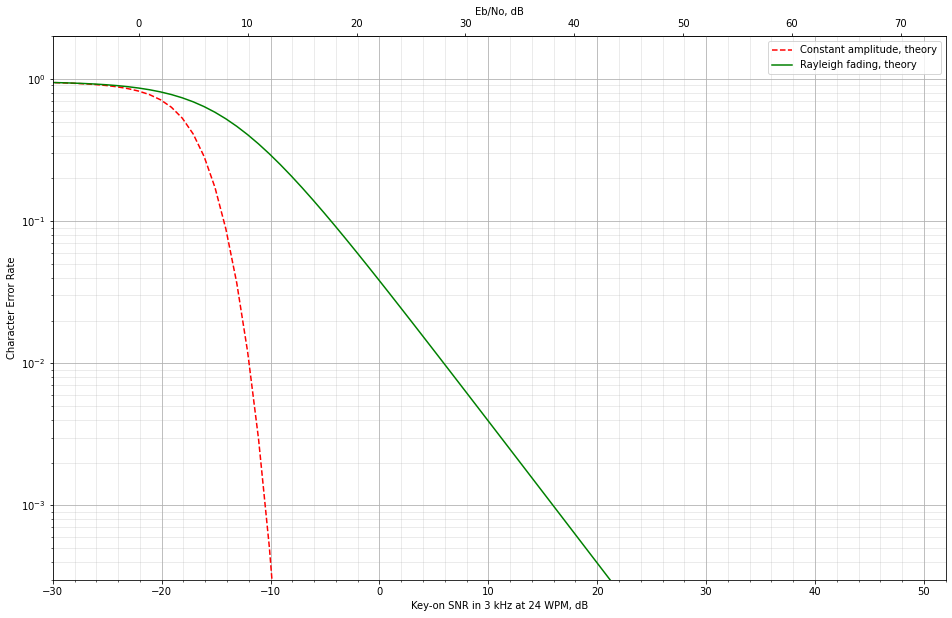

In [6]:
import axes
ax = axes.plot_axes()
plt.show()